# Image Segmentation
- REDNet Fine Tuning
  - https://dambaekday.tistory.com/3
  - https://m.blog.naver.com/laonple/220985349467

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [14]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Oxford_IIIT Pet Dataset

### 1) 학습용 'Image'와 'Label' 다운로드
  - 'Image'의 경계선과 내용, 외곽 3가지 분류 학습

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.2.0' ,
                          with_info = True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteYJVTS2/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteYJVTS2/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
# tfds 에러시 사용(코드가 끊겼으니 후에 보강할 것)

# !python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets = ox

### 2) Dataset Information
- feature
  - image - shape = (None, None, 3)
  - label - num_classes = 37
  - segmentation_mask - shape = (None, None, 1)

- split
  - train : 3680
  - test : 3669

In [6]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

### 3) train, test 데이터 수 저장

In [7]:
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples

## 2. load_image()

### 1) 함수 정의
  - 'image' and 'segmentation_mask'
  - resize : (128, 128)
  - Normalization

In [9]:
def load_image(datapoint) :
  img = tf.image.resize(datapoint['image'] , (128, 128))
  mask = tf.image.resize(datapoint['segmentation_mask'] , (128, 128))

  img = tf.cast(img, tf.float32)
  img = img / 255.0
  mask -= 1

  return img, mask

### 2) 'train_dataset' and 'test_dataset' 정의

In [10]:
train_dataset = dataset['train'].map(load_image)

train_dataset

<MapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [11]:
train_dataset = train_dataset.repeat()

train_dataset

<RepeatDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [12]:
train_dataset = train_dataset.batch(16)

train_dataset

<BatchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

In [13]:
test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

## 3. 'image' and 'segmentation_mask' 확인
- 각 필셀의 값을 중심부, 배경, 외곽선으로 분류하는 문제
  - 중심부: '1'
  - 배경: '2'
  - 외곽선: '3'
- mask의 'label'이 '0'부터 시작하도록 설정

0.3996089 0.00047392002


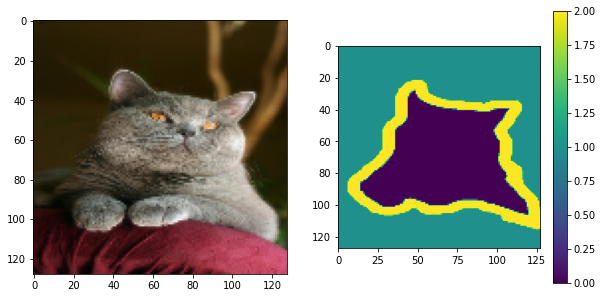

In [15]:
for img, mask in train_dataset.take(1) :
  plt.figure(figsize = (10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow(img[2])

  plt.subplot(1, 2, 2)
  plt.imshow(np.squeeze(mask[2], axis = 2))
  plt.colorbar()

  print(np.amax(img[1][2]), np.amin(img[1][2]))

## 4. REDNet Fine Tuning

### 1) 마지막 레이어 수정
- deconv_layers: 'softmax' Activation

In [21]:
def REDNet_segmentation(num_layers):
  conv_layers = []
  deconv_layers = []
  residual_layers = []

  inputs = tf.keras.layers.Input(shape = (None, None, 3))

  conv_layers.append(tf.keras.layers.Conv2D(3,
                                            kernel_size = 3,
                                            padding = 'same',
                                            activation = 'relu'))
  
  for i in range(num_layers - 1) :
    conv_layers.append(tf.keras.layers.Conv2D(64,
                                              kernel_size = 3,
                                              padding = 'same',
                                              activation = 'relu'))
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(64,
                                                         kernel_size = 3,
                                                         padding = 'same',
                                                         activation = 'relu'))
    
  deconv_layers.append(tf.keras.layers.Conv2DTranspose(3,
                                                       kernel_size = 3,
                                                       padding = 'same',
                                                       activation = 'softmax'))
  
  x = conv_layers[0](inputs)

  for i in range(num_layers - 1):
    x = conv_layers[i+1](x)
    if i % 2 == 0 :
      residual_layers.append(x)

  for i in range(num_layers - 1) :
    if i % 2 == 1 :
      x = tf.keras.layers.Add()([x, residual_layers.pop()])
      x = tf.keras.layers.Activation('relu')(x)
    x = deconv_layers[i](x)

    x = deconv_layers[-1](x)

    model = tf.keras.Model(inputs = inputs, outputs = x)

    return model

### 2) Model Compile

In [22]:
model = REDNet_segmentation(15)
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.optimizers.Adam(0.0001),
              metrics = ['accuracy'])

### 3) Model Fit

In [23]:
%%time

history = model.fit(train_dataset,
                    epochs = 20,
                    steps_per_epoch = train_data_len // 16,
                    validation_data = test_dataset,
                    validation_steps = test_data_len)

Epoch 1/20
230/230 [==============================] - 84s 230ms/step - loss: 0.9574 - accuracy: 0.5699 - val_loss: 0.8126 - val_accuracy: 0.5731
Epoch 2/20
230/230 [==============================] - 54s 235ms/step - loss: 0.7619 - accuracy: 0.6126 - val_loss: 0.7182 - val_accuracy: 0.6605
Epoch 3/20
230/230 [==============================] - 54s 234ms/step - loss: 0.6825 - accuracy: 0.6911 - val_loss: 0.6879 - val_accuracy: 0.6908
Epoch 4/20
230/230 [==============================] - 54s 235ms/step - loss: 0.6432 - accuracy: 0.7155 - val_loss: 0.6412 - val_accuracy: 0.7138
Epoch 5/20
230/230 [==============================] - 54s 234ms/step - loss: 0.6152 - accuracy: 0.7314 - val_loss: 0.6090 - val_accuracy: 0.7334
Epoch 6/20
230/230 [==============================] - 54s 236ms/step - loss: 0.5956 - accuracy: 0.7422 - val_loss: 0.5752 - val_accuracy: 0.7527
Epoch 7/20
230/230 [==============================] - 54s 234ms/step - loss: 0.5773 - accuracy: 0.7515 - val_loss: 0.5645 - val_ac

## 5. Model Validation

### 1) 테스트 이미지 분할 확인
- 'image', 'segmentation_mask', 'learned_mask'

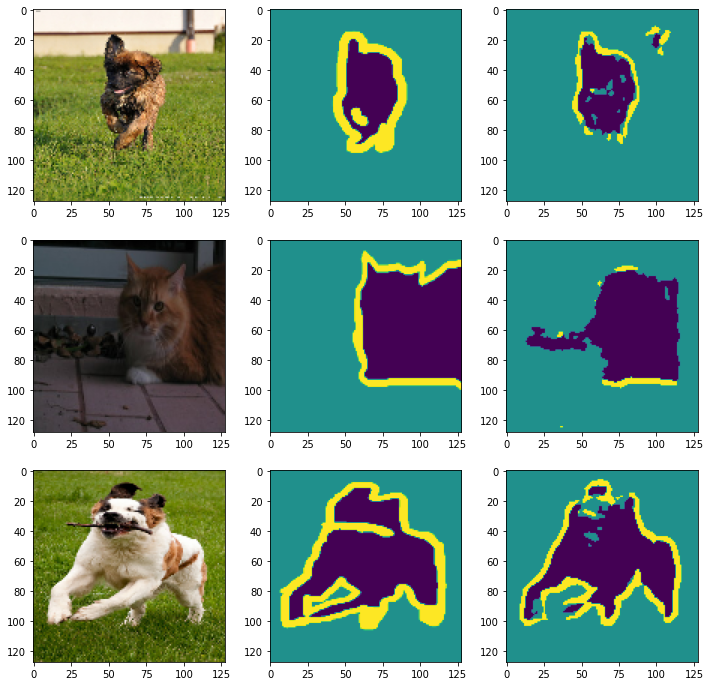

In [24]:
plt.figure(figsize = (12, 12))

for idx, (img, mask) in enumerate(test_dataset.take(3)):
  plt.subplot(3, 3, idx*3 + 1)
  plt.imshow(img[0])

  plt.subplot(3, 3, idx*3 + 2)
  plt.imshow(np.squeeze(mask[0], axis = 2))

  predict = tf.argmax(model.predict(img), axis = -1)
  plt.subplot(3, 3, idx*3 + 3)
  plt.imshow(np.squeeze(predict, axis = 0))

### 2) 테스트 이미지 분할 확인(원본)

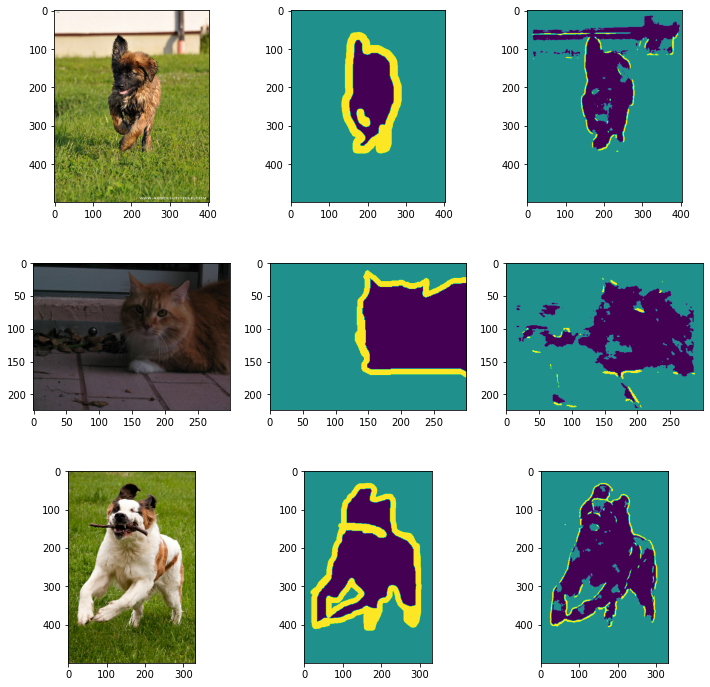

In [25]:
plt.figure(figsize = (12, 12))

for idx, datapoint in enumerate(dataset['test'].take(3)):
  img = datapoint['image']
  mask = datapoint['segmentation_mask']

  img = tf.cast(img, tf.float32)
  img = img / 255.0
  mask -= 1

  plt.subplot(3, 3, idx*3 + 1)
  plt.imshow(img)

  plt.subplot(3, 3, idx*3 + 2)
  plt.imshow(np.squeeze(mask, axis = 2))

  predict = tf.argmax(model.predict(tf.expand_dims(img, axis = 0)), axis = -1)
  plt.subplot(3, 3, idx*3 + 3)
  plt.imshow(np.squeeze(predict, axis = 0))